In [221]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
from PIL import Image
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

def sigmoid(Z):
    return 1. / (1. + np.exp(-Z))

def sigmoid_(Z):
    A = 1. / (1. + np.exp(-Z))
    return A*(1.-A)

def relu(Z):
    Z[Z<0] = 0.
    return Z

def relu_(Z):
    Z[Z>=0] = 1.
    Z[Z<0] = 0.
    return Z

def leakyRelu(Z):
    Z[Z<0] = 0.01 * Z[Z<0]
    return Z

def leakyRelu_(Z):
    Z[Z>=0] = 1.
    Z[Z<0] = 0.01
    return Z

def softmax(Z):
    A = np.exp(Z-Z.mean(axis=0, keepdims=True))
    softmax_sum = A.sum(axis=0, keepdims=True)
    return A / softmax_sum

def softmax_(Z):
    A = np.exp(Z-Z.mean())
    softmax_sum = A.sum(axis=0, keepdims=True)
    return A * (softmax_sum - A) / (softmax_sum ** 2)

def L_binaryClassfication(A, Y):
    return -(Y * np.log(A) + (1 - Y) * np.log(1 - A))

def L_binaryClassfication_(A, Y):
    return -(Y / (A + 0.1**8) + (1 - Y) / (1 - A + 0.1**8))

def L_cross_entropy(A, Y):
    return -Y*np.log(A + 0.1**8)

def L_cross_entropy_(A, Y):
    return -Y/(A + 0.1**8)


def forward(A_prev, W, b, g):
    Z = W.dot(A_prev) + b
    A= g(Z)
    return Z, A


def backward(A_prev, W, Z, g_, dA):
    dZ = dA * g_(Z)
    dW = dA.dot(A_prev.T)
    db = dA
    dA_prev = W.T.dot(dA)
    return dA_prev, dW, db, dZ


def get_pars(n_pre, n):
    W = np.random.rand(n, n_pre)
    W = W / W.sum()
    b = np.random.rand(n, 1)
    b = b / b.sum()
    Z = []
    A = []
    dW = []
    db = []
    dZ = []
    dA = []
    return W, b, Z, A, dW, db, dZ, dA


# batch training
def train(getXY, itr, a):
    # define net structure and initialize parameters
    m = 128
    W1, b1, Z1, A1, dW1, db1, dZ1, dA1 = get_pars(28 * 28, 28)
    W2, b2, Z2, A2, dW2, db2, dZ2, dA2 = get_pars(28, 16)
    W3, b3, Z3, A3, dW3, db3, dZ3, dA3 = get_pars(16, 10)

    train_loss = []
    dev_loss = []

    for i in range(0, itr):
        trainA0, trainY, devA0, devY = getXY()

        # train
        # forward
        A0 = trainA0
        Z1, A1 = forward(A0, W1, b1, relu)
        Z2, A2 = forward(A1, W2, b2, relu)
        Z3, A3 = forward(A2, W3, b3, softmax)

        # get loss
        los = L_cross_entropy(A3, trainY)
        train_loss.append(los.sum() / m)

        # backward propagation
        dA3 = los * L_cross_entropy_(A3, trainY)
        dA2, dW3, db3, dZ3 = backward(A2, W3, Z3, softmax_, dA3)
        dA1, dW2, db2, dZ2 = backward(A1, W2, Z2, relu_, dA2)
        dA0, dW1, db1, dZ1 = backward(A0, W1, Z1, relu_, dA1)

        print(i, "=================================================================")
        print(los)

        # refresh the data
        W1 = W1 - a * dW1 / m
        b1 = b1 - a * db1.sum(axis=1, keepdims=True) / m

        W2 = W2 - a * dW2 / m
        b2 = b2 - a * db2.sum(axis=1, keepdims=True) / m

        W3 = W3 - a * dW3 / m
        b3 = b3 - a * db3.sum(axis=1, keepdims=True) / m

    plt.plot(train_loss)
    plt.plot(dev_loss)
    plt.show()


train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./../data/', train=True, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=128, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./../data/', train=False, download=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=128, shuffle=True)


def reshape(imgs, labels):
    img_shape = np.array(imgs).shape
    x = np.array(imgs).flatten('C').reshape(-1, img_shape[2] * img_shape[3], order='C').T
    x = x / x.sum()
    y = np.array([np.array(labels).tolist()])
    softmax_y = np.zeros((10, y.shape[1]))
    for i in range(0, y.shape[1]):
        softmax_y[y[0, i], i] = 1
    return x, softmax_y


def getXY():
    train_batch = enumerate(train_loader)
    batch_idx, (train_imgs, train_labels) = next(train_batch)
    train_x, train_y = reshape(train_imgs, train_labels)

    test_batch = enumerate(test_loader)
    batch_idx, (test_imgs, test_labels) = next(test_batch)
    test_x, test_y = reshape(test_imgs, test_labels)

    return train_x, train_y, test_x, test_y


def house_price():
    neuralNet = NeuralNet()
    df_x = pd.read_csv("./data/house_price/test.csv")
    df_y = pd.read_csv("./data/house_price/price.csv")
    features = ['MSSubClass', 'LotFrontage', 'LotArea']
    x = np.array(df_x[features].T,)
    y = np.array([np.array(df_y['SalePrice'].T).tolist()])





train(getXY, 10000, 0.003)







0 =================================================================
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 2.18988505 0.         0.        ]
 [0.         2.34043698 2.34043698 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [2.40498123 0.         0.         ... 0.         2.40498123 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
1 =================================================================
[[0.         0.         2.19710015 ... 0.         2.19710015 0.        ]
 [0.         0.         0.         ... 2.19144259 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         2.38976141 0.         ... 0.         

18 =================================================================
[[0.         2.23006657 0.         ... 0.         0.         0.        ]
 [0.         0.         2.18449379 ... 0.         2.18449382 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         2.27797708]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
19 =================================================================
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         2.1840931  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         2.39454961 0.         ... 2.39454961 0.         0.        ]
 [0.         0.         0.         ... 0.       

34 =================================================================
[[0.         0.         0.         ... 0.         0.         2.25195455]
 [2.1889091  0.         0.         ... 0.         0.         0.        ]
 [0.         2.31582784 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         2.28529937 0.        ]
 [0.         0.         2.38040063 ... 2.38040065 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
35 =================================================================
[[0.         0.         0.         ... 0.         0.         2.25199781]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         2.28794836 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         2.34993302 ... 0.       

50 =================================================================
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         2.19093809 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         2.33634204 ... 2.33634207 0.         0.        ]]
51 =================================================================
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         2.30628637 0.         ... 0.         2.30628638 0.        ]
 ...
 [2.28903914 0.         2.28903914 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.       

69 =================================================================
[[0.         0.         0.         ... 2.29498638 0.         2.29498628]
 [2.20229169 0.         0.         ... 0.         0.         0.        ]
 [0.         2.31102587 0.         ... 0.         2.31102585 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
70 =================================================================
[[0.         0.         2.2936699  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         2.20675882]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         2.35050206 0.         ... 0.         2.35050207 0.        ]
 [2.34764971 0.         0.         ... 2.3476497

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 2.31615986 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
86 =================================================================
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [2.31539063 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         2.31872603 ... 2.31872605 0.         0.        ]]
87 ========================================

104 =================================================================
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 2.21657582 0.         0.        ]
 [0.         0.         0.         ... 0.         2.29323459 0.        ]
 ...
 [0.         2.24822299 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         2.33119282]
 [0.         0.         2.35105891 ... 0.         0.         0.        ]]
105 =================================================================
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         2.221758  ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         2.23488292 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [2.33659859 0.         0.         ... 0.     

123 =================================================================
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         2.42933859 2.42934257]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         2.16315508 0.         ... 0.         0.         0.        ]]
124 =================================================================
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 2.2461128  0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [2.13043982 0.         0.         ... 0.         0.         2.130437  ]
 [0.         0.         0.         ... 0.         2.31717387 0.        ]
 [0.         0.         0.         ... 0.     

<ipython-input-221-0e46804c8c7c>:36: RuntimeWarning: overflow encountered in exp
  A = np.exp(Z-Z.mean(axis=0, keepdims=True))
<ipython-input-221-0e46804c8c7c>:38: RuntimeWarning: invalid value encountered in true_divide
  return A / softmax_sum
<ipython-input-221-0e46804c8c7c>:41: RuntimeWarning: overflow encountered in exp
  A = np.exp(Z-Z.mean())
<ipython-input-221-0e46804c8c7c>:43: RuntimeWarning: invalid value encountered in subtract
  return A * (softmax_sum - A) / (softmax_sum ** 2)
<ipython-input-221-0e46804c8c7c>:43: RuntimeWarning: invalid value encountered in multiply
  return A * (softmax_sum - A) / (softmax_sum ** 2)


135 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
136 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
137 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
138 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan .

170 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
171 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
172 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
173 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan .

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
203 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
204 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
205 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
206 ==================

236 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
237 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
238 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
239 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan .

271 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
272 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
273 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
274 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan .

303 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
304 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
305 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
306 =================================================================
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan .

KeyboardInterrupt: 

In [43]:
def f(a):
    return a+1
b = eval('f')

In [44]:
b(1)

2

In [7]:
df_x = pd.read_csv("./../data/house_price/test.csv")
df_y = pd.read_csv("./../data/house_price/price.csv")
features = ['MSSubClass', 'LotFrontage', 'LotArea']
x = np.array(df_x[features].T)
y = np.array([np.array(df_y['SalePrice'].T).tolist()])

In [8]:
df_x.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object

In [9]:
df_y.dtypes

Id             int64
SalePrice    float64
dtype: object

In [10]:
print(x)

[[   20.    20.    60. ...    20.    85.    60.]
 [   80.    81.    74. ...   160.    62.    74.]
 [11622. 14267. 13830. ... 20000. 10441.  9627.]]


In [11]:
print(y)

[[169277.0524984  187758.39398877 183583.68356955 ... 219222.42340006
  184924.279659   187741.86665748]]


In [12]:
import numpy as np
y = np.array([[1,2,3,4]])
softmax_y = np.zeros((10, y.shape[1]))

for i in range(0, y.shape[1]):
    softmax_y[y[0,i], i] = 1

print(softmax_y)

[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [13]:
a = [[1,2],[3,4],[5,6]]
b = [[1,2,3,4,5,6]]
print(b[0][1])

2


### plot loss

KeyboardInterrupt: 

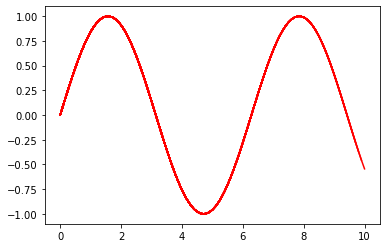

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import time
from math import *
 
plt.ion() #开启interactive mode 成功的关键函数
plt.figure(1)
t = [0]
t_now = 0
m = [sin(t_now)]
 
for i in range(2000):
     t_now = i*0.1
     t.append(t_now)#模拟数据增量流入
     m.append(sin(t_now))#模拟数据增量流入
     plt.plot(t,m,'-r')
     plt.draw()#注意此函数需要调用
     time.sleep(0.01)

In [ ]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
 
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
 from IPython import display
 
plt.ion()
 
def plot_durations(y):
 plt.figure(2)
 plt.clf()
 plt.subplot(211)
 plt.plot(y[:,0])
 plt.subplot(212)
 plt.plot(y[:,1])
 
 plt.pause(0.001) # pause a bit so that plots are updated
 if is_ipython:
  display.clear_output(wait=True)
  display.display(plt.gcf())
 
 
x = np.linspace(-10,10,500)
y = []
for i in range(len(x)):
 y1 = np.cos(i/(3*3.14))
 y2 = np.sin(i/(3*3.14))
 y.append(np.array([y1,y2]))
 plot_durations(np.array(y))

In [ ]:
ddP.max(axis=0).repeat(3)

### Save weights
+ np: np.savetxt, np.readtxt 
+ fileIO: write and read list
+ json

In [15]:
np.loadtxt("a.txt", dtype='float64', delimiter=' ') 

OSError: a.txt not found.

In [ ]:
time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) 

In [ ]:
list_data = [[1,2], [2,2,2],[[1,2],[3,4]]]

open(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) +'data.txt','w').write(str(list_data))


In [ ]:
file = open('data.txt','r') 
a = file.read()

In [ ]:
print(a)

In [ ]:
np.readline

In [ ]:
file = open('others.txt', 'w')
file.writelines(str([[1,2,3], 'function']))

file.close()

In [ ]:
file = open('others.txt', 'r')
arr = file.readlines()
func = file.readlines()
print(list(arr))


##### json 存储weights 

In [ ]:
import json
data = {'a': [1,2,3], 'b':[[1,2],[3,4]], 'c':'adsfa'}
js = json.dumps(data)

In [ ]:
js

In [ ]:
ddd = json.loads(js)

In [ ]:
ddd['a']

In [ ]:
ddd['b']

In [ ]:
ccc = np.array([[1,2,3],[5,5,5]])
print(ccc)
ccc[:,0] = [[9], [9]]
print(ccc)


In [ ]:
print('asdf', 'asdf')

In [ ]:
a = [[1,2,3], [12],"qwer"]

In [ ]:
del a[1:]

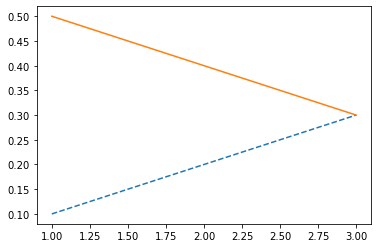

In [21]:
plt.plot([1,2,3],[0.1,0.2,0.3],'--')
plt.plot([1,2,3],[0.5,0.4,0.3],'-')
plt.annotate()
plt.show()

In [23]:
class A:
    m=1
    def aa(self, m = 0):
        print(m)
    
a =A()
a.aa()
a.aa(10)


0
10


In [37]:
a = np.array([[]])
b = np.array([[1]])

In [38]:
print(a.shape)
print(b.shape)


(1, 0)
(1, 1)


In [39]:
print(len(a))
print(len(b))

1
1


In [40]:
len([[],[]])

2

In [17]:
a = np.array([[1,2,3,4],[3,3,3,3]])

In [20]:
(a.argmax(axis=0) == np.array([1,0,1,0])).sum()

2

In [21]:
a = np.zeros((3,4))

In [23]:
b = np.ones((3,1))

In [24]:
print(a)
print(b)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[1.]
 [1.]
 [1.]]


In [29]:
a[:,0] = b[:,0]

In [30]:
a

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [28]:
a

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])